# Perform CNN using Keras for 13x classes over AWS


In [ ]:
!pip install keras==2.1.5

In [ ]:
!pip install tensorflow==1.1.0

In [1]:
import tensorflow
tensorflow.__version__

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


'1.1.0'

In [2]:
import keras
keras.__version__

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFile
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import itertools
import h5py

%matplotlib inline  


# Functions for lots later

In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(16,16), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image preparation

In [6]:
train_path = 'dataset/training_set'
valid_path = 'dataset/validation_set'
test_path = 'dataset/test_set'

In [7]:
# Define batches
# ImageDataGenerator() is a keras object which generates batches of tensor image data.
# flow_from_directory is where you tell keras where is your images, and their labels.
# flow_from_directory also turns the labels to one-hot-encoded based. chopper=[0,0,1,0...0], clock=[1,0,0...0] 
# In this case we assigned 128x128 only because it yields a better result.
# If using VGG16, we had to change to 224x224, because VGG16 takes this size as inputs.
# If you are working on different classes such as xray images, a different size may be apply to achieve better result.
# This is a trail and error thing.

train_batches = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True).flow_from_directory(train_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                                   batch_size = 20)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 20)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 130)

Found 14970 images belonging to 13 classes.
Found 2593 images belonging to 13 classes.
Found 130 images belonging to 13 classes.


We put batch size 20. This is the number of images we will be grabbing for iteration.

In [8]:
# Every time we run this, a next sets of 20 images.
imgs, labels = next(train_batches)

In [9]:
# below are 1x batch, here are the lables.
labels

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 

In [10]:
len(imgs)

20

In [11]:
imgs

array([[[[5.39673746e-01, 5.28724492e-01, 5.29539883e-01],
         [5.61788678e-01, 5.50827563e-01, 5.51631093e-01],
         [5.69375157e-01, 5.62077999e-01, 5.59495986e-01],
         ...,
         [9.24504817e-01, 9.33836162e-01, 9.33896184e-01],
         [9.22692120e-01, 9.33774769e-01, 9.33092654e-01],
         [9.17588472e-01, 9.28659260e-01, 9.27965224e-01]],

        [[5.61221421e-01, 5.58053732e-01, 5.59637606e-01],
         [5.60388863e-01, 5.57209313e-01, 5.58799088e-01],
         [5.50563812e-01, 5.48619330e-01, 5.46527207e-01],
         ...,
         [8.87606919e-01, 9.03291404e-01, 9.10835981e-01],
         [8.82008016e-01, 8.99283290e-01, 9.06382799e-01],
         [8.70680153e-01, 8.87949467e-01, 8.95037055e-01]],

        [[5.60469389e-01, 5.55855513e-01, 5.58162451e-01],
         [5.54090977e-01, 5.51757634e-01, 5.52924335e-01],
         [5.50928116e-01, 5.50928116e-01, 5.49657166e-01],
         ...,
         [8.69108796e-01, 8.86422276e-01, 8.98769498e-01],
         [

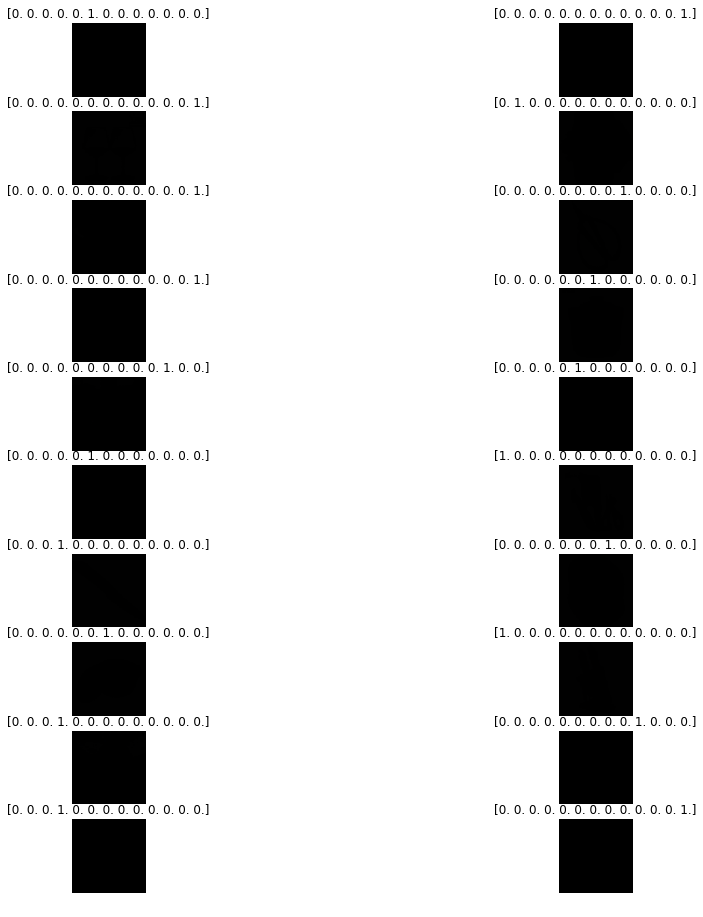

In [12]:
# Batches of 20
plots(imgs, titles = labels)

In [13]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

#### prepare csv to save training logs

In [14]:
# Training with callbacks
from keras import callbacks

filename='logs_6May_700epoch.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)


# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

# Bulid CNN model

In [15]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))  # no of filter 32# can be 3x3 5x5, 7x7 # input shape 128x128 resolution # 3 RGB
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  # X no. of filters, 3x3 shape of filters, produces feature maps.
classifier.add(MaxPooling2D(pool_size = (2, 2)))      # takes the max value in matrix, but still retained details, reduces size of matrix

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Flatten())  # noel... this turns 2d to 1d
classifier.add(Dense(units = 128, activation = 'relu'))  # noel.. this is number of nodes from input.

classifier.add(Dense(units = 13, activation = 'softmax'))  # 13 classes
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
# Viewing model_configuration

classifier.summary()
classifier.get_config()
classifier.layers[0].get_config()
classifier.layers[0].input_shape
classifier.layers[0].output_shape
classifier.layers[0].get_weights()
np.shape(classifier.layers[0].get_weights()[0])
classifier.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
__________

True

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Training starts NOW!!

In [18]:
# steps_per_epoch =  no. of images /  batch_no.
classifier.fit_generator(train_batches, steps_per_epoch = 20, 
                         validation_data = valid_batches, validation_steps = 20, 
                         epochs = 700, verbose = 2, callbacks=callbacks_list)

Epoch 1/700


/home/ec2-user/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 - 10s - loss: 2.5569 - acc: 0.0625 - val_loss: 2.5800 - val_acc: 0.0625
Epoch 2/700
 - 7s - loss: 2.5244 - acc: 0.0900 - val_loss: 2.5525 - val_acc: 0.1300
Epoch 3/700
 - 7s - loss: 2.4468 - acc: 0.1800 - val_loss: 2.5606 - val_acc: 0.1175
Epoch 4/700
 - 7s - loss: 2.3734 - acc: 0.2150 - val_loss: 2.4431 - val_acc: 0.2750
Epoch 5/700
 - 7s - loss: 2.3990 - acc: 0.1975 - val_loss: 2.3635 - val_acc: 0.2200
Epoch 6/700
 - 7s - loss: 2.3018 - acc: 0.2000 - val_loss: 2.2777 - val_acc: 0.3050
Epoch 7/700
 - 7s - loss: 2.0814 - acc: 0.3150 - val_loss: 2.6777 - val_acc: 0.2150
Epoch 8/700
 - 7s - loss: 2.0329 - acc: 0.2925 - val_loss: 2.0380 - val_acc: 0.3125
Epoch 9/700
 - 7s - loss: 2.0729 - acc: 0.3000 - val_loss: 1.9895 - val_acc: 0.3225
Epoch 10/700
 - 7s - loss: 1.8850 - acc: 0.3800 - val_loss: 1.9310 - val_acc: 0.3550
Epoch 11/700
 - 7s - loss: 1.9470 - acc: 0.3250 - val_loss: 1.8710 - val_acc: 0.3750
Epoch 12/700
 - 7s - loss: 1.8959 - acc: 0.3650 - val_loss: 1.8702 - val_acc: 0.3800


Epoch 97/700
 - 13s - loss: 0.9423 - acc: 0.7025 - val_loss: 0.8172 - val_acc: 0.7600
Epoch 98/700
 - 13s - loss: 1.0415 - acc: 0.6475 - val_loss: 0.8886 - val_acc: 0.7425
Epoch 99/700
 - 13s - loss: 1.0122 - acc: 0.6525 - val_loss: 0.9002 - val_acc: 0.7400
Epoch 100/700
 - 13s - loss: 0.9595 - acc: 0.7025 - val_loss: 0.8818 - val_acc: 0.7425
Epoch 101/700
 - 13s - loss: 0.8960 - acc: 0.7100 - val_loss: 0.8428 - val_acc: 0.7550
Epoch 102/700
 - 13s - loss: 0.8054 - acc: 0.7400 - val_loss: 0.8174 - val_acc: 0.7525
Epoch 103/700
 - 13s - loss: 0.9669 - acc: 0.6900 - val_loss: 0.9509 - val_acc: 0.7275
Epoch 104/700
 - 13s - loss: 1.0929 - acc: 0.6400 - val_loss: 0.8639 - val_acc: 0.7600
Epoch 105/700
 - 13s - loss: 0.9438 - acc: 0.6750 - val_loss: 0.8418 - val_acc: 0.7600
Epoch 106/700
 - 13s - loss: 0.9416 - acc: 0.7000 - val_loss: 0.8642 - val_acc: 0.7375
Epoch 107/700
 - 13s - loss: 0.9548 - acc: 0.6850 - val_loss: 0.8351 - val_acc: 0.7550
Epoch 108/700
 - 13s - loss: 0.9282 - acc: 0.6

Epoch 192/700
 - 13s - loss: 0.7805 - acc: 0.7575 - val_loss: 0.7251 - val_acc: 0.7625
Epoch 193/700
 - 13s - loss: 0.8622 - acc: 0.7175 - val_loss: 0.7327 - val_acc: 0.7725
Epoch 194/700
 - 13s - loss: 0.7802 - acc: 0.7450 - val_loss: 0.8382 - val_acc: 0.7550
Epoch 195/700
 - 13s - loss: 0.7348 - acc: 0.7700 - val_loss: 0.6916 - val_acc: 0.7800
Epoch 196/700
 - 13s - loss: 0.7415 - acc: 0.7775 - val_loss: 0.6888 - val_acc: 0.7900
Epoch 197/700
 - 13s - loss: 0.7739 - acc: 0.7550 - val_loss: 0.7075 - val_acc: 0.7825
Epoch 198/700
 - 13s - loss: 0.6967 - acc: 0.7750 - val_loss: 0.6900 - val_acc: 0.7925
Epoch 199/700
 - 14s - loss: 0.8237 - acc: 0.7075 - val_loss: 0.7010 - val_acc: 0.8025
Epoch 200/700
 - 13s - loss: 0.8517 - acc: 0.7275 - val_loss: 0.6980 - val_acc: 0.7875
Epoch 201/700
 - 13s - loss: 0.7313 - acc: 0.7550 - val_loss: 0.6765 - val_acc: 0.7900
Epoch 202/700
 - 13s - loss: 0.7665 - acc: 0.7350 - val_loss: 0.8402 - val_acc: 0.7575
Epoch 203/700
 - 13s - loss: 0.7547 - acc: 

Epoch 287/700
 - 14s - loss: 0.6522 - acc: 0.7475 - val_loss: 0.5837 - val_acc: 0.8150
Epoch 288/700
 - 13s - loss: 0.6911 - acc: 0.7900 - val_loss: 0.6416 - val_acc: 0.8075
Epoch 289/700
 - 13s - loss: 0.6566 - acc: 0.7825 - val_loss: 0.6195 - val_acc: 0.8200
Epoch 290/700
 - 13s - loss: 0.7308 - acc: 0.7650 - val_loss: 0.6459 - val_acc: 0.8125
Epoch 291/700
 - 13s - loss: 0.5941 - acc: 0.8025 - val_loss: 0.6615 - val_acc: 0.8100
Epoch 292/700
 - 14s - loss: 0.6130 - acc: 0.8075 - val_loss: 0.7270 - val_acc: 0.8000
Epoch 293/700
 - 13s - loss: 0.6445 - acc: 0.7725 - val_loss: 0.6322 - val_acc: 0.8200
Epoch 294/700
 - 13s - loss: 0.8254 - acc: 0.7300 - val_loss: 0.6394 - val_acc: 0.8125
Epoch 295/700
 - 14s - loss: 0.6446 - acc: 0.8025 - val_loss: 0.6451 - val_acc: 0.7950
Epoch 296/700
 - 13s - loss: 0.6951 - acc: 0.7700 - val_loss: 0.6491 - val_acc: 0.8175
Epoch 297/700
 - 13s - loss: 0.5930 - acc: 0.8075 - val_loss: 0.6374 - val_acc: 0.8025
Epoch 298/700
 - 13s - loss: 0.6182 - acc: 

Epoch 382/700
 - 13s - loss: 0.5933 - acc: 0.8050 - val_loss: 0.6148 - val_acc: 0.8075
Epoch 383/700
 - 13s - loss: 0.5368 - acc: 0.8325 - val_loss: 0.5828 - val_acc: 0.8100
Epoch 384/700
 - 13s - loss: 0.5915 - acc: 0.8150 - val_loss: 0.7314 - val_acc: 0.7975
Epoch 385/700
 - 14s - loss: 0.6894 - acc: 0.7650 - val_loss: 0.6426 - val_acc: 0.8075
Epoch 386/700
 - 13s - loss: 0.5847 - acc: 0.8025 - val_loss: 0.5930 - val_acc: 0.8275
Epoch 387/700
 - 13s - loss: 0.6434 - acc: 0.7875 - val_loss: 0.5491 - val_acc: 0.8250
Epoch 388/700
 - 13s - loss: 0.5983 - acc: 0.7975 - val_loss: 0.5021 - val_acc: 0.8425
Epoch 389/700
 - 13s - loss: 0.6142 - acc: 0.7900 - val_loss: 0.5374 - val_acc: 0.8250
Epoch 390/700
 - 13s - loss: 0.5538 - acc: 0.8125 - val_loss: 0.5450 - val_acc: 0.8200
Epoch 391/700
 - 13s - loss: 0.6807 - acc: 0.8025 - val_loss: 0.5612 - val_acc: 0.8050
Epoch 392/700
 - 13s - loss: 0.6221 - acc: 0.7875 - val_loss: 0.5854 - val_acc: 0.8075
Epoch 393/700
 - 13s - loss: 0.7455 - acc: 

Epoch 477/700
 - 7s - loss: 0.5613 - acc: 0.8125 - val_loss: 0.5158 - val_acc: 0.8425
Epoch 478/700
 - 7s - loss: 0.5666 - acc: 0.8350 - val_loss: 0.6099 - val_acc: 0.8125
Epoch 479/700
 - 7s - loss: 0.5710 - acc: 0.8000 - val_loss: 0.5569 - val_acc: 0.8200
Epoch 480/700
 - 7s - loss: 0.5451 - acc: 0.8075 - val_loss: 0.6133 - val_acc: 0.8125
Epoch 481/700
 - 7s - loss: 0.5645 - acc: 0.7800 - val_loss: 0.5476 - val_acc: 0.8175
Epoch 482/700
 - 10s - loss: 0.5468 - acc: 0.8425 - val_loss: 0.5712 - val_acc: 0.8150
Epoch 483/700
 - 15s - loss: 0.5613 - acc: 0.8350 - val_loss: 0.6778 - val_acc: 0.8025
Epoch 484/700
 - 14s - loss: 0.6265 - acc: 0.7675 - val_loss: 0.5687 - val_acc: 0.8250
Epoch 485/700
 - 15s - loss: 0.6499 - acc: 0.7750 - val_loss: 0.5017 - val_acc: 0.8450
Epoch 486/700
 - 14s - loss: 0.4764 - acc: 0.8400 - val_loss: 0.5456 - val_acc: 0.8200
Epoch 487/700
 - 15s - loss: 0.5602 - acc: 0.8000 - val_loss: 0.5479 - val_acc: 0.8175
Epoch 488/700
 - 15s - loss: 0.5165 - acc: 0.817

Epoch 572/700
 - 15s - loss: 0.5170 - acc: 0.8350 - val_loss: 0.5355 - val_acc: 0.8325
Epoch 573/700
 - 15s - loss: 0.5436 - acc: 0.8150 - val_loss: 0.5807 - val_acc: 0.8200
Epoch 574/700
 - 13s - loss: 0.6129 - acc: 0.8175 - val_loss: 0.5629 - val_acc: 0.8175
Epoch 575/700
 - 15s - loss: 0.5631 - acc: 0.8250 - val_loss: 0.5275 - val_acc: 0.8200
Epoch 576/700
 - 15s - loss: 0.4131 - acc: 0.8675 - val_loss: 0.5148 - val_acc: 0.8250
Epoch 577/700
 - 14s - loss: 0.4694 - acc: 0.8450 - val_loss: 0.5354 - val_acc: 0.8250
Epoch 578/700
 - 15s - loss: 0.5651 - acc: 0.8125 - val_loss: 0.5118 - val_acc: 0.8300
Epoch 579/700
 - 14s - loss: 0.4573 - acc: 0.8525 - val_loss: 0.4732 - val_acc: 0.8550
Epoch 580/700
 - 15s - loss: 0.5802 - acc: 0.8275 - val_loss: 0.5391 - val_acc: 0.8225
Epoch 581/700
 - 13s - loss: 0.4786 - acc: 0.8550 - val_loss: 0.5110 - val_acc: 0.8375
Epoch 582/700
 - 14s - loss: 0.6113 - acc: 0.8150 - val_loss: 0.5259 - val_acc: 0.8350
Epoch 583/700
 - 14s - loss: 0.5512 - acc: 

Epoch 667/700
 - 14s - loss: 0.5398 - acc: 0.8150 - val_loss: 0.5020 - val_acc: 0.8300
Epoch 668/700
 - 14s - loss: 0.4713 - acc: 0.8475 - val_loss: 0.4752 - val_acc: 0.8300
Epoch 669/700
 - 14s - loss: 0.5222 - acc: 0.8350 - val_loss: 0.4971 - val_acc: 0.8100
Epoch 670/700
 - 14s - loss: 0.5110 - acc: 0.8225 - val_loss: 0.5070 - val_acc: 0.8425
Epoch 671/700
 - 14s - loss: 0.5839 - acc: 0.8000 - val_loss: 0.5079 - val_acc: 0.8375
Epoch 672/700
 - 15s - loss: 0.5033 - acc: 0.8325 - val_loss: 0.5093 - val_acc: 0.8250
Epoch 673/700
 - 15s - loss: 0.4508 - acc: 0.8575 - val_loss: 0.4873 - val_acc: 0.8325
Epoch 674/700
 - 13s - loss: 0.4974 - acc: 0.8350 - val_loss: 0.4826 - val_acc: 0.8300
Epoch 675/700
 - 18s - loss: 0.4609 - acc: 0.8500 - val_loss: 0.4918 - val_acc: 0.8350
Epoch 676/700
 - 14s - loss: 0.5456 - acc: 0.8400 - val_loss: 0.4855 - val_acc: 0.8225
Epoch 677/700
 - 14s - loss: 0.5691 - acc: 0.8175 - val_loss: 0.4888 - val_acc: 0.8325
Epoch 678/700
 - 15s - loss: 0.4676 - acc: 

# Save weights and model to a h5 file 

This save functions saves:
    - The architecture of the model, allowing to re-create the model.
    - The weights of themodel.
    - The training configuraton (loss, optimaizer)
    - The state of the optimizer, allowing to resume training exactly where you left off

In [19]:
classifier.save('cnn_model_weights_700.h5')

In [20]:
model_json = classifier.to_json()
with open("cnn_model_700.json","w") as json_file:
    json_file.write(model_json)

In [21]:
classifier.save_weights("cnn_weights_700.h5")

# Prediction

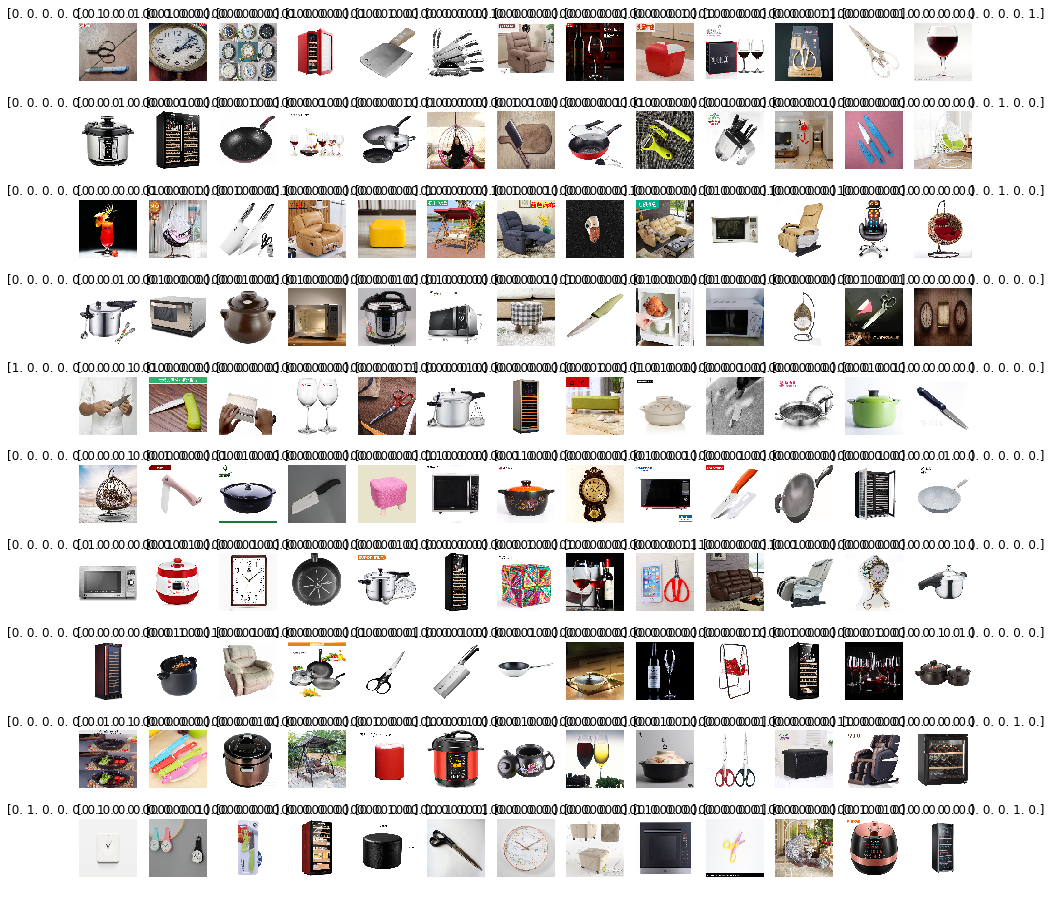

In [22]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [23]:
test_labels_1 = test_labels[:,12]
test_labels_1

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [24]:
pred = classifier.predict_generator(test_batches, steps=1, verbose=0)

In [25]:
#checks
len(pred)

130

In [26]:
#checks
np.argmax(pred, axis=1)

array([ 8,  1,  1, 11,  0,  0,  1, 12,  1, 12,  1,  8, 12,  7, 11,  2, 12,
        8,  1,  8,  2,  3,  1,  1,  8,  0,  1,  1,  8,  1,  9, 12,  1,  1,
        1,  5,  8,  0,  1,  1,  0,  7,  0,  1,  1, 12,  8,  0,  5, 10,  8,
        1,  8,  8,  8, 12,  2,  1, 11,  8,  4,  1,  8,  8,  3, 10,  8,  1,
        8,  8,  5,  6,  1,  5,  8,  8, 11,  2,  5,  1,  1,  1,  1, 11, 12,
       12,  8, 10,  8,  1,  7, 11,  7,  1,  8,  8,  0,  8,  8, 12,  0, 11,
       12,  2,  8,  8,  1,  1,  7,  7,  8, 12,  1,  8,  5,  4, 11,  1,  8,
        8, 11,  7,  8,  1,  1,  5,  0,  1,  1, 11])

In [27]:
# checks
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

#### Confusion Matrix

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[ 3,  2,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 1,  5,  0,  0,  1,  0,  0,  0,  2,  0,  1,  0,  0],
       [ 3,  1,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  1,  0,  1,  2,  3,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  1,  0,  2,  2,  1,  0,  0,  2],
       [ 2,  5,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]])

Confusion matrix, without normalization
[[ 3  2  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  3  0  0  0  0  0  6  0  0  0  0]
 [ 0  1  0  2  0  0  0  0  7  0  0  0  0]
 [ 1  5  0  0  1  0  0  0  2  0  1  0  0]
 [ 3  1  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  2  1  0  1  0  1  2  3  0  0  0  0]
 [ 0  7  0  0  0  0  0  3  0  0  0  0  0]
 [ 1  1  1  0  0  0  0  0  7  0  0  0  0]
 [ 0  2  0  0  0  1  0  2  2  1  0  0  2]
 [ 2  5  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  9]]


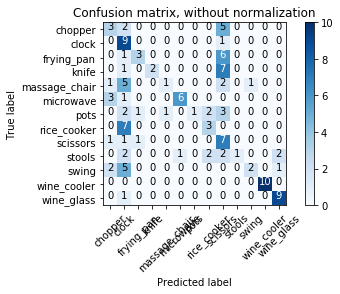

In [29]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                      title='Confusion matrix, without normalization')

#### Classification report

In [30]:
classes=['chopper','clock','frying_pan','knife','massage_chair','microwave', 'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1),target_names=classes))

               precision    recall  f1-score   support

      chopper       0.30      0.30      0.30        10
        clock       0.24      0.90      0.38        10
   frying_pan       0.60      0.30      0.40        10
        knife       1.00      0.20      0.33        10
massage_chair       0.50      0.10      0.17        10
    microwave       0.86      0.60      0.71        10
         pots       1.00      0.10      0.18        10
  rice_cooker       0.43      0.30      0.35        10
     scissors       0.21      0.70      0.33        10
       stools       1.00      0.10      0.18        10
        swing       0.67      0.20      0.31        10
  wine_cooler       1.00      1.00      1.00        10
   wine_glass       0.75      0.90      0.82        10

  avg / total       0.66      0.44      0.42       130



#### LIVE Demo image prediction

In [31]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

In [32]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

Predict below item is a :  wine_cooler


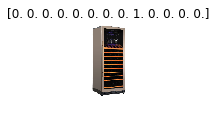

In [35]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 128, 128

# load the model we saved
model = load_model('cnn_model_weights_700.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# predicting images
img = image.load_img('./dataset/test_set/wine_cooler/70984.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)

plots(images, titles=test_labels)
listclass = list(train_batches.class_indices.keys())
print('Predict below item is a : ', listclass[classes[0]])